In [26]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

final_project_path = '/Users/johansweldens/Documents/EECS6691.ADL/final_project'
data_folder_path = os.path.join(final_project_path, 'segment_data')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')


annotations_name = '_annotations.coco.json'
train_annotations_path = os.path.join(train_folder_path, annotations_name)
valid_annotations_path = os.path.join(valid_folder_path, annotations_name)

# Load annotations from JSON file
with open(train_annotations_path, 'r') as f:
    train_annotations_data = json.load(f)
with open(valid_annotations_path, 'r') as f:
    valid_annotations_data = json.load(f)

# Create a dictionary to map category IDs to category names
category_id_to_name = {category['id']: category['name'] for category in train_annotations_data['categories']}
print(train_annotations_data['info'])
# print(train_annotations_data['annotations'])
print(train_annotations_data['categories'])
print(train_annotations_data.keys())




# Extract categories from the annotations
categories = train_annotations_data['categories']

# Count the number of unique category IDs
num_classes = len(set([category['id'] for category in categories]))

print("Number of classes:", num_classes)



{'year': '2023', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-08-19T04:37:54+00:00'}
[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'Tumor'}, {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Number of classes: 3


## Display the Images

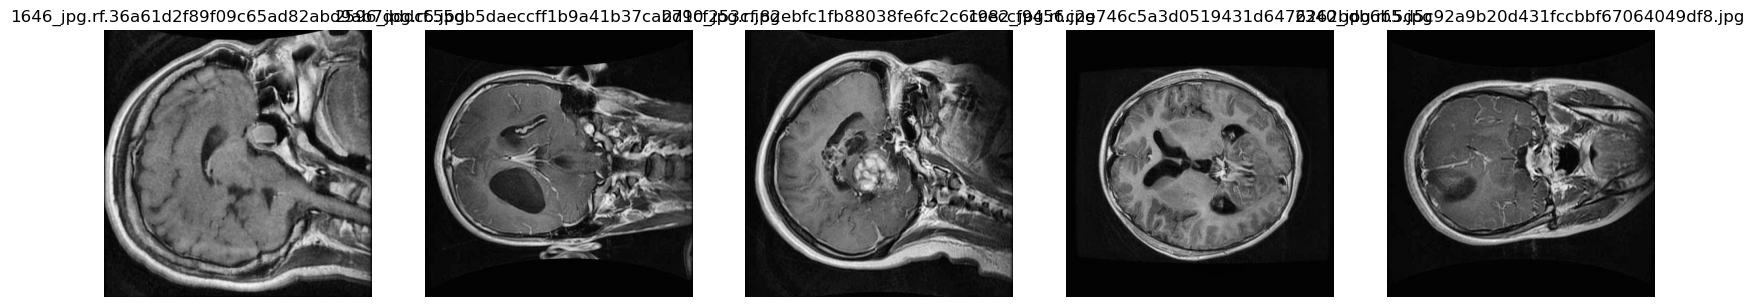

Number of Training Images: 1502


In [27]:
image_files = [f for f in os.listdir(train_folder_path) if f.endswith('.jpg')]

# Display 5 random images
num_images_to_display = 5
selected_images = np.random.choice(image_files, num_images_to_display, replace=False)

# Set up matplotlib figure
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))


# Loop through selected images and display them
for i, image_file in enumerate(selected_images):
    image_path = os.path.join(train_folder_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(image_file)

plt.show()
print("Number of Training Images:", len(image_files))

[289, 273, 52.5, 78.75]
[214, 233, 153.75, 171.25]
[273, 134, 198.75, 181.25]
[73, 310, 117.5, 107.5]
[216, 260, 143.75, 122.5]


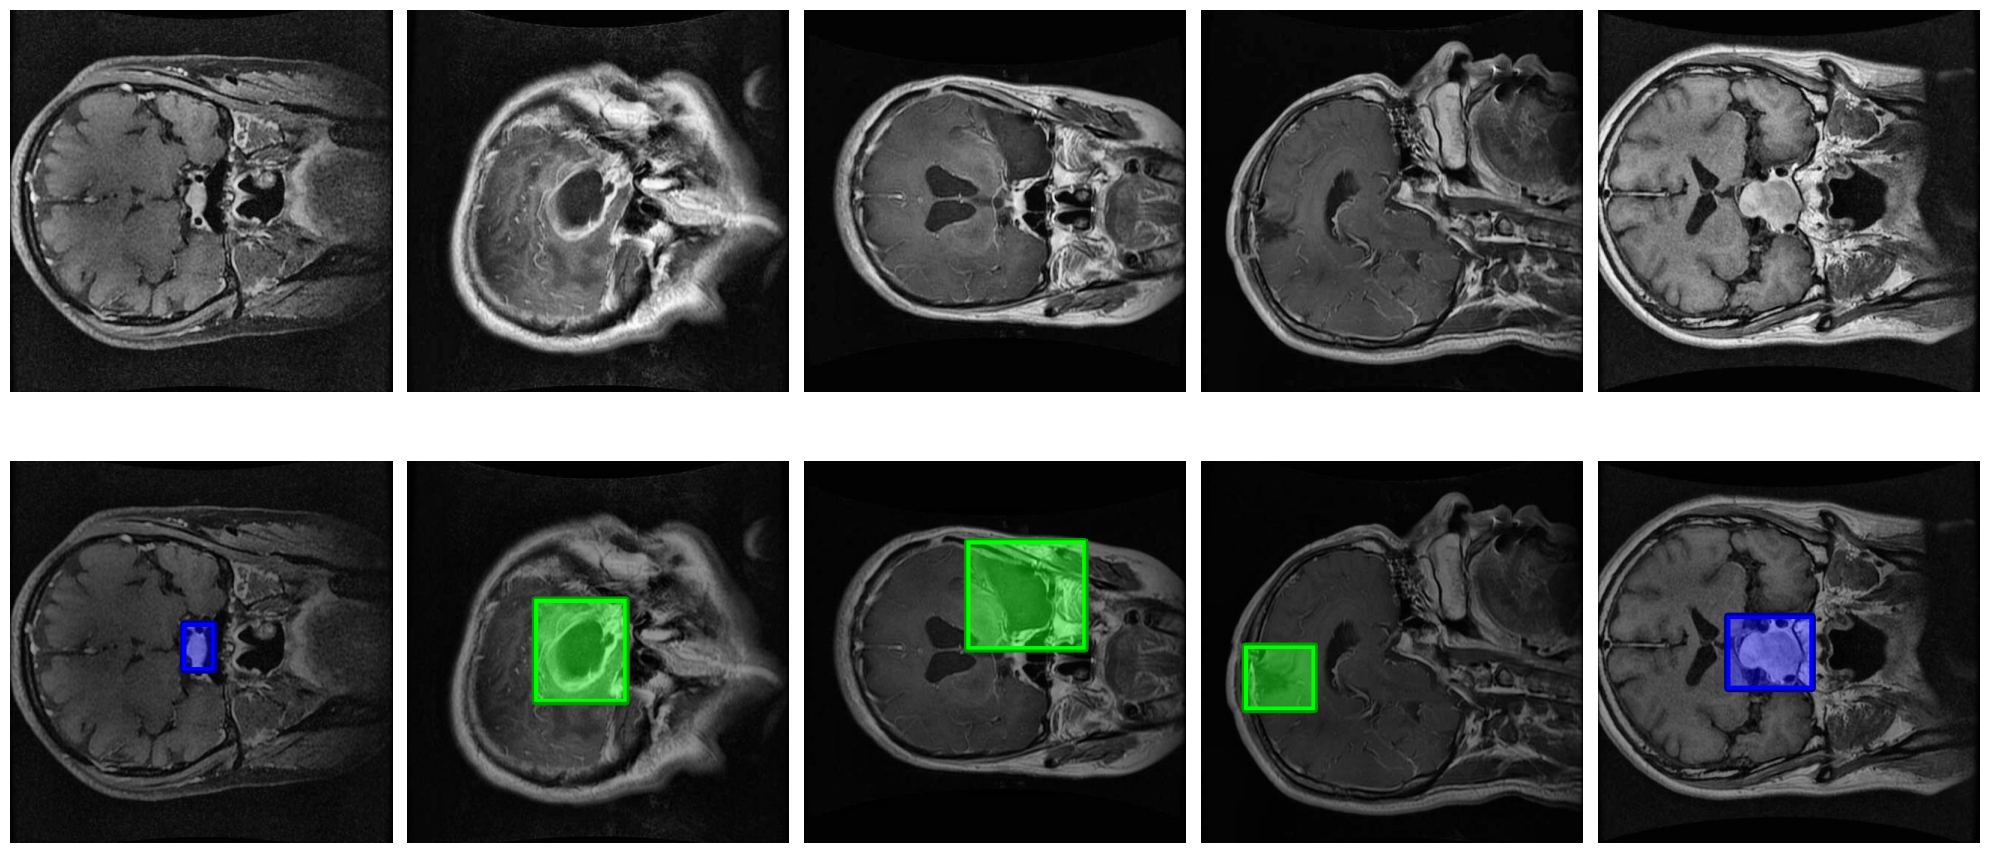

In [28]:


# Define colors for each class
colors = {
    0: (255, 0, 0),  # Tumor (Red)
    1: (0, 255, 0),   # Other class (Green)
    2: (0, 0, 255)   # Other class (Green)
}

# Display 5 random images
num_images_to_display = 5
selected_images = np.random.choice(train_annotations_data['images'], num_images_to_display, replace=False)

# Set up matplotlib figure
fig, axes = plt.subplots(2, num_images_to_display, figsize=(20, 10))

# Loop through selected images and display them with segmentation masks
for i, image_info in enumerate(selected_images):
    image_id = image_info['id']
    image_file_name = image_info['file_name']
    image_path = os.path.join(train_folder_path, image_file_name)
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display raw image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    
    # Find annotations for the current image
    annotations = [ann for ann in train_annotations_data['annotations'] if ann['image_id'] == image_id]
    
    # Create a mask image for overlaying segmentation
    mask = np.zeros_like(image)
    
    # Loop through annotations and draw segmentation masks
    for ann in annotations:
        category_id = ann['category_id']
        segmentation = ann['segmentation']
        bbox = ann['bbox']
        print(bbox)
        color = colors[category_id]
        # Extract bounding box coordinates
        x, y, w, h = [int(coord) for coord in bbox]
        
        # Draw bounding box on the image
        segmented_image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 10)
        
        # Draw segmentation mask
        for segment in segmentation:
            points = np.array(segment).reshape((-1, 1, 2)).astype(np.int32)
            cv2.fillPoly(mask, [points], color)
            
    
    # Overlay segmentation mask on the original image
    segmented_image = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    
    # Display image with segmentation
    axes[1, i].imshow(segmented_image)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Create the Databasesimport os


In [108]:
## all images are clean and 640 by 640

import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, data_folder, annotations, image_size=(640, 640), transform=None):
        self.data_folder = data_folder
        self.annotations = annotations
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.data_folder, self.annotations[idx]['file_name'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        # Generate mask
        mask = self.generate_mask_from_annotations()

        return image, mask

    def generate_mask_from_annotations(self):
        # Generate mask from annotations
        mask = np.zeros(self.image_size, dtype=np.uint8)
        for annotation_data in self.annotations:
            # Extract annotation points and draw rectangle on the mask
            # Last point is the same as the first point
            points = annotation_data['segmentation'][0]
            rect_points = np.array(points).reshape((-1, 2))
            cv2.fillPoly(mask, [rect_points], color=(255))

        return mask

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize to a standard size
    transforms.ToTensor(),
])


In [111]:
# Define data paths
train_data_folder = os.path.join(data_folder_path, 'train')
val_data_folder = os.path.join(data_folder_path, 'valid')

# Create datasets
train_dataset = ImageDataset(train_data_folder, train_annotations_data, image_size=(640, 640), transform=transform)
val_dataset = ImageDataset(val_data_folder, valid_annotations_data, image_size=(640, 640), transform=transform)

print("Train Dataset", train_dataset)
print("Val Dataset", val_dataset)



Train Dataset <__main__.ImageDataset object at 0x287af5150>
Val Dataset <__main__.ImageDataset object at 0x2826d3710>


## Model Architecture